In [2]:
%load_ext jupyter_black

In [26]:
import pandas as pd
import numpy as np

# from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    StandardScaler,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    log_loss,
)
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pickle
from umap import UMAP

In [72]:
train = pd.read_parquet("../data/splits/train.parquet")
test = pd.read_parquet("../data/splits/train.parquet")

academic_columns = train.columns[train.columns.str.contains("first|second")]

# Divide the dataset in X and y
X = train.drop(columns=["dropout"])
y = train["dropout"]

X_test = test.drop(columns=["dropout"])
y_test = test["dropout"]

In [73]:
def feat_eng(df):
    df = df.copy()
    # Create a column of percentage of exams approved
    df = df.assign(
        # Number of approved units over total number of evaluations (its not a percentage of approved exams)
        first_sem_approved_over_evaluations=lambda x: x.first_sem_approved
        / x.first_sem_evaluations,
        second_sem_approved_over_evaluations=lambda x: x.second_sem_approved
        / x.second_sem_evaluations,
        # There are some students with 0 evaluations in the semesters, the coefficient will be np.nan value.
        # I will fill these with the mean value and create a boolean flag
        first_sem_has_evals=lambda x: x.first_sem_evaluations != 0,
        second_sem_has_evals=lambda x: x.second_sem_evaluations != 0,
        # Boolean flag for sem_without_evaluations predictors
        first_sem_has_units_without_evals=lambda x: x.first_sem_without_evaluations
        == 0,
        second_sem_has_units_without_evals=lambda x: x.second_sem_without_evaluations
        == 0,
        # Ratio of average grade over number of enrolled units
        first_sem_grade_over_enrolled=lambda x: x.first_sem_grade
        / x.first_sem_enrolled,
        second_sem_grade_over_enrolled=lambda x: x.second_sem_grade
        / x.second_sem_enrolled,
        # Again, there are some students with 0 enrolled units in the semesters, the coefficient will be np.nan value.
        # I will fill these with the mean value and create a boolean flag
        first_sem_has_enrolled=lambda x: x.first_sem_enrolled != 0,
        second_sem_has_enrolled=lambda x: x.second_sem_enrolled != 0,
        # Number of disapproved units
        first_sem_disapproved=lambda x: x.first_sem_enrolled - x.first_sem_approved,
        second_sem_disapproved=lambda x: x.second_sem_enrolled - x.second_sem_approved,
        # Percentage of units credited over enrolled
        first_sem_perc_credited=lambda x: x.first_sem_credited / x.first_sem_enrolled,
        second_sem_perc_credited=lambda x: x.second_sem_credited
        / x.second_sem_enrolled,
    )
    df = df.drop(columns=["nationality", "international"])
    return df


X_fe = X.pipe(feat_eng)
X_fe_test = X_test.pipe(feat_eng)

In [76]:
X_fe.columns

Index(['marital_status', 'application_mode', 'application_order', 'course',
       'day_evening', 'previous_education', 'mother_education',
       'father_education', 'mother_occupation', 'father_occupation',
       'displaced', 'special_needs', 'debtor', 'tuition_fees_up_to_date',
       'gender', 'scholarship_holder', 'age_at_enrollment',
       'first_sem_credited', 'first_sem_enrolled', 'first_sem_evaluations',
       'first_sem_approved', 'first_sem_grade',
       'first_sem_without_evaluations', 'second_sem_credited',
       'second_sem_enrolled', 'second_sem_evaluations', 'second_sem_approved',
       'second_sem_grade', 'second_sem_without_evaluations',
       'unemployment_rate', 'inflation_rate', 'gdp_change',
       'first_sem_approved_over_evaluations',
       'second_sem_approved_over_evaluations', 'first_sem_has_evals',
       'second_sem_has_evals', 'first_sem_has_units_without_evals',
       'second_sem_has_units_without_evals', 'first_sem_grade_over_enrolled',
       '

In [7]:
# Prepare the cross validation splitter
splits = StratifiedKFold(n_splits=4, shuffle=True, random_state=93)

In [17]:
# Load the dictionary with the features selected by the different methods
with open("../data/features_selected.pkl", "rb") as f:
    features_selected = pickle.load(f)

features_selected["all_features"] = X_fe.columns

In [40]:
# Data preprocessors

# Encode the non-numerical variables with ordinal encoder
ord_enc_preproc = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Encode the non-numerical variables with one hot encoder
ohe_preproc = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore"),
        make_column_selector(dtype_exclude=np.number),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Transform the academic columns with UMAP

umap_preproc = make_column_transformer(
    (
        make_pipeline(StandardScaler(), UMAP(n_components=3, n_neighbors=10)),
        academic_columns,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

## Random Forest Baseline

I will create a random forest classifier and train it with the different selected variables from the feature selection notebook, to see if there is a difference in performance

In [24]:
rfc_pipe = make_pipeline(
    ord_enc_preproc,
    SimpleImputer(strategy="mean"),
    RandomForestClassifier(n_estimators=500, min_samples_split=3),
)

scoring = "neg_log_loss"

scores = {}

for name, features in features_selected.items():
    score = cross_val_score(
        rfc_pipe,
        X_fe[features],
        y,
        scoring=scoring,
        cv=splits,
        n_jobs=3,
    )
    scores[name] = score

In [41]:
rfc_pipe_umap = make_pipeline(
    ord_enc_preproc,
    umap_preproc,
    SimpleImputer(strategy="mean"),
    RandomForestClassifier(n_estimators=500, min_samples_split=3),
)

score = cross_val_score(
    rfc_pipe_umap,
    X_fe,
    y,
    scoring=scoring,
    cv=splits,
    n_jobs=3,
)
scores["umap"] = score

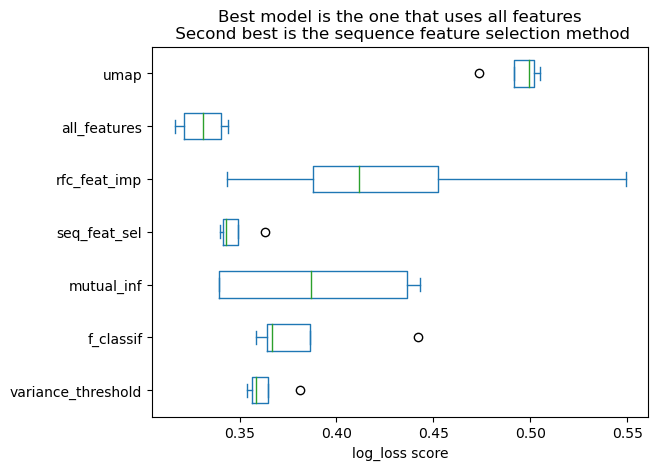

In [44]:
pd.DataFrame(scores).mul(-1).plot.box(vert=False)
plt.title(
    "Best model is the one that uses all features\n Second best is the sequence feature selection method"
)
plt.xlabel("log_loss score")
plt.show()

In [41]:
preds = cross_val_predict(
    rfc_pipe, X_fe[features_selected["seq_feat_sel"]], y, cv=splits, n_jobs=-1
)

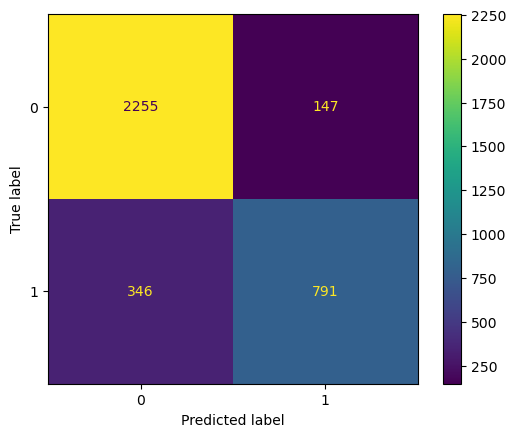

In [42]:
ConfusionMatrixDisplay.from_predictions(y, preds)

In [44]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2402
           1       0.84      0.70      0.76      1137

    accuracy                           0.86      3539
   macro avg       0.86      0.82      0.83      3539
weighted avg       0.86      0.86      0.86      3539



In [47]:
log_loss(
    y,
    cross_val_predict(
        rfc_pipe,
        X_fe[features_selected["seq_feat_sel"]],
        y,
        cv=splits,
        n_jobs=-1,
        method="predict_proba",
    ),
)

0.34733795406612694

In [96]:
preds = cross_val_predict(rfc_pipe, X_fe, y, cv=splits, n_jobs=-1)

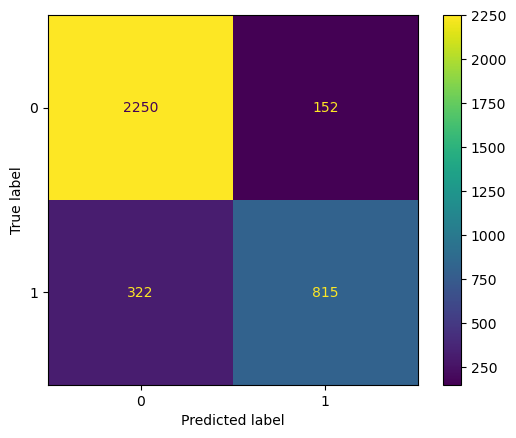

In [97]:
ConfusionMatrixDisplay.from_predictions(y, preds)

In [98]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2402
           1       0.84      0.72      0.77      1137

    accuracy                           0.87      3539
   macro avg       0.86      0.83      0.84      3539
weighted avg       0.86      0.87      0.86      3539



## Lasso model

In [77]:


lasso_pipe = make_pipeline(
    ohe_preproc, SimpleImputer(strategy="constant", fill_value=-1), LassoCV()
)

lasso_pipe.fit(X_fe, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001CD18CB11C0>)],
                                   verbose_feature_names_out=False)),
                ('simpleimputer',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('lassocv', LassoCV())])

In [79]:
mse_lasso = pd.DataFrame(
    {
        "mse": lasso_pipe[-1].mse_path_.mean(axis=1),
        "dev": lasso_pipe[-1].mse_path_.std(axis=1),
        "alpha": lasso_pipe[-1].alphas_,
    }
).assign(m_min=lambda x: x.mse - x.dev, m_max=lambda x: x.mse + x.dev)

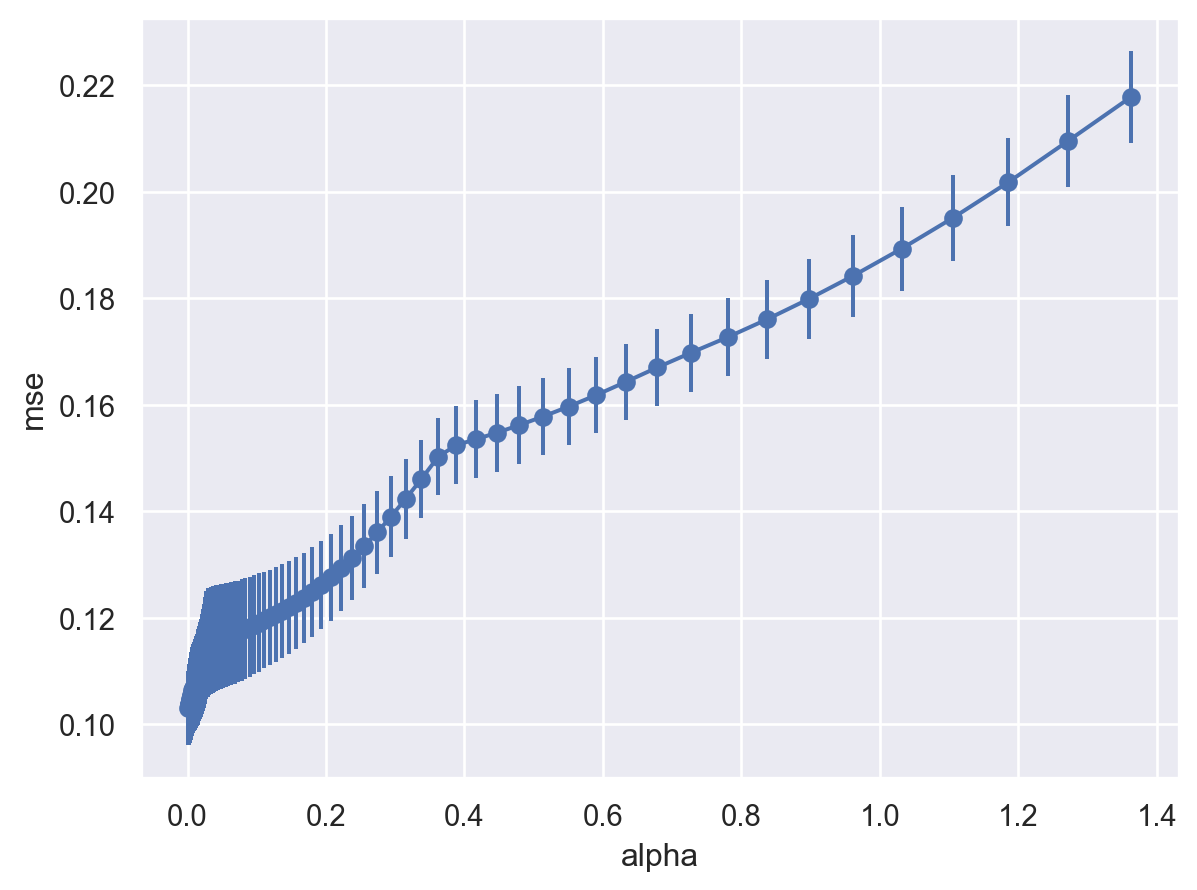

In [80]:
(
    so.Plot(mse_lasso, x="alpha", y="mse", ymin="m_min", ymax="m_max")
    .add(so.Line(marker="o"))
    .add(so.Range())
)

In [82]:
importances = pd.Series(
    np.abs(lasso_pipe[-1].coef_), index=lasso_pipe[0].get_feature_names_out()
)
importances.sort_values(ascending=False).nlargest(15)

tuition_fees_up_to_date_no                                       0.265051
mother_education_Basic Education 3rd Cycle                       0.115284
course_Basic Education                                           0.086497
mother_occupation_Student                                        0.082883
course_Equiniculture                                             0.075254
second_sem_disapproved                                           0.073211
debtor_no                                                        0.056010
course_Social Service                                            0.051086
previous_education_Higher Education                              0.045015
first_sem_has_units_without_evals_False                          0.033706
application_mode_Technological specialization diploma holders    0.032625
scholarship_holder_no                                            0.031587
application_mode_2nd phase - general contingent                  0.030992
course_Veterinary Nursing             

In [83]:
preds = cross_val_predict(lasso_pipe, X_fe, y, cv=splits, n_jobs=-1)

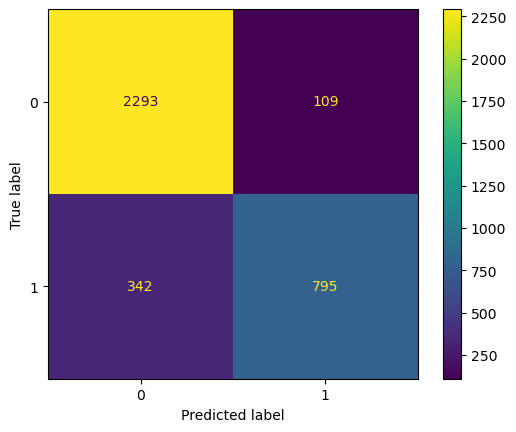

In [86]:
ConfusionMatrixDisplay.from_predictions(y, preds > 0.5)

In [87]:
print(classification_report(y, preds > 0.5))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2402
           1       0.88      0.70      0.78      1137

    accuracy                           0.87      3539
   macro avg       0.87      0.83      0.84      3539
weighted avg       0.87      0.87      0.87      3539



## XGBoost model

In [45]:
from xgboost import XGBClassifier

In [46]:
xgb_pipe = make_pipeline(
    ord_enc_preproc,
    SimpleImputer(strategy="mean"),
    XGBClassifier(),
)

xgb_score = cross_val_score(
    xgb_pipe,
    X_fe,
    y,
    scoring=scoring,
    cv=splits,
    n_jobs=3,
)

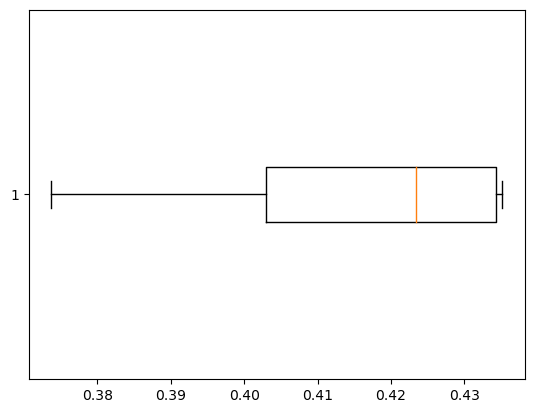

In [52]:
plt.boxplot(x=xgb_score * -1, vert=False)
plt.show()

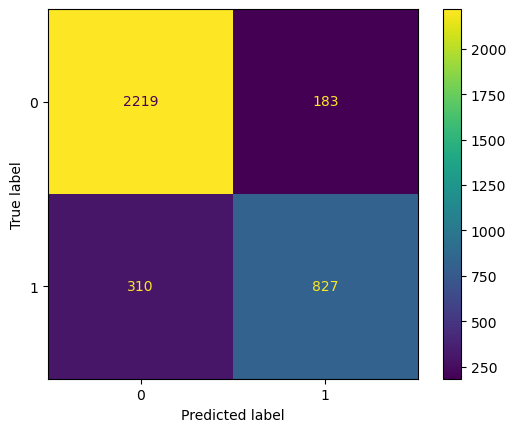

In [53]:
preds = cross_val_predict(xgb_pipe, X_fe, y, cv=splits, n_jobs=-1)
ConfusionMatrixDisplay.from_predictions(y, preds)

# Model Selection

From these models, the one with the lowest `log_loss` error is the Random Forest Classifier that uses all the features, so this is the model I will be selecting and perform hyperparameter tunning. The second best model is the Random Forest Classifier that uses only 3 features, that is remarkable! I will also perform hyperparameter tunning on this model.

In [63]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in range(100, 501, 100)]
# Number of features to consider at every split
max_features = [None, "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num=9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# SimpleImputer strategy
strategy = ["mean", "median", "constant"]
# Create the random grid
random_grid = {
    "simpleimputer__strategy": strategy,
    "randomforestclassifier__n_estimators": n_estimators,
    "randomforestclassifier__max_features": max_features,
    "randomforestclassifier__max_depth": max_depth,
    "randomforestclassifier__min_samples_split": min_samples_split,
    "randomforestclassifier__min_samples_leaf": min_samples_leaf,
    "randomforestclassifier__bootstrap": bootstrap,
}

In [67]:
rfc_pipe = make_pipeline(
    ord_enc_preproc,
    SimpleImputer(fill_value=0),
    RandomForestClassifier(n_estimators=500, min_samples_split=3),
)

rfc_grid = RandomizedSearchCV(
    estimator=rfc_pipe,
    param_distributions=random_grid,
    n_iter=50,
    cv=splits,
    verbose=True,
    random_state=35,
    n_jobs=-1,
    scoring="neg_log_loss",
)

rfc_grid.fit(X_fe, y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


c:\Users\Matias\miniconda3\envs\dropout_analysis\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=93, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002483729E34...
                                                                              55,
                                                                              66,
                                                                              77,
                                                                              88,
                                                                              100,
                                                                              None],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 200,
                                                                                 300,
                                                                                 400,
                                                                                 500],
                                        'simpleimputer__strategy': ['mean',
                                                                    'median',
                                                                    'constant']},
                   random_state=35, scoring='neg_log_loss', verbose=True)

In [68]:
rfc_grid.best_params_

{'simpleimputer__strategy': 'constant',
 'randomforestclassifier__n_estimators': 500,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__bootstrap': False}

In [69]:
rfc_grid.best_score_

-0.3278168627994006

In [71]:
rfc_estimator = rfc_grid.best_estimator_

In [74]:
test_preds = rfc_estimator.predict(X_fe_test)

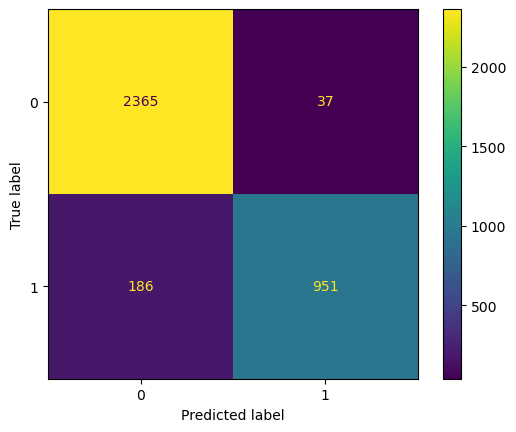

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

In [77]:
test_preds_proba = rfc_estimator.predict_proba(X_fe_test)

In [78]:
log_loss(y_test, test_preds_proba)

0.2027257667760592

In [79]:
from joblib import dump

dump(rfc_estimator, "../models/rfc_all_features.joblib")

['../models/rfc_all_features.joblib']

Since we will use the probability of dropout, it would be good to check if the model is calibrated. Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to, say, 0.8, approximately 80% actually belong to the positive class.

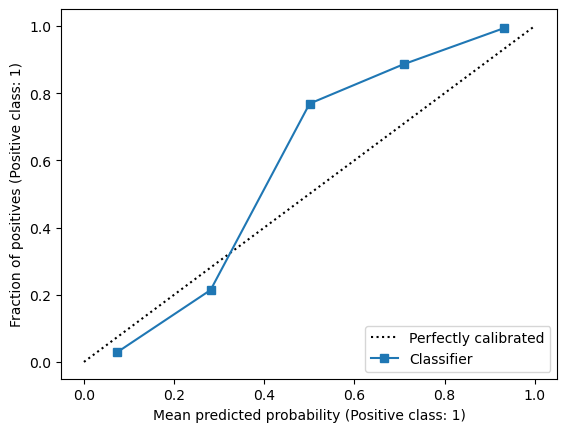

In [82]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_test, test_preds_proba[:, 1])

Perfect, we can use this estimator to make predictions

Now, lets perform the hyperparameter tunning on the model with 3 features

In [83]:
rfc_grid_2 = RandomizedSearchCV(
    estimator=rfc_pipe,
    param_distributions=random_grid,
    n_iter=50,
    cv=splits,
    verbose=True,
    random_state=35,
    n_jobs=-1,
    scoring="neg_log_loss",
)

rfc_grid_2.fit(X_fe[features_selected["seq_feat_sel"]], y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=93, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000002483729E34...
                                                                              55,
                                                                              66,
                                                                              77,
                                                                              88,
                                                                              100,
                                                                              None],
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt'],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     4],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 200,
                                                                                 300,
                                                                                 400,
                                                                                 500],
                                        'simpleimputer__strategy': ['mean',
                                                                    'median',
                                                                    'constant']},
                   random_state=35, scoring='neg_log_loss', verbose=True)

In [85]:
rfc_grid_2.best_score_

-0.34713742903141553

In [86]:
rfc_grid_2.best_params_

{'simpleimputer__strategy': 'constant',
 'randomforestclassifier__n_estimators': 500,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 55,
 'randomforestclassifier__bootstrap': True}

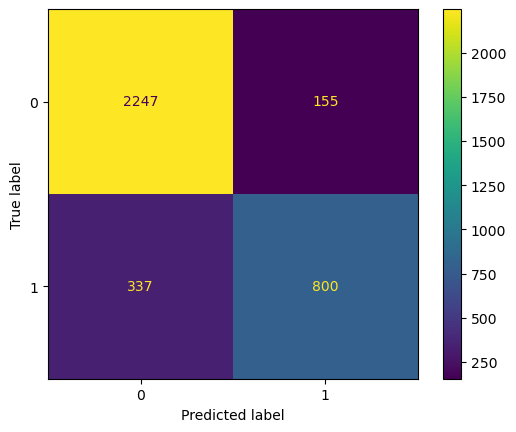

In [87]:
rfc_estimator_2 = rfc_grid_2.best_estimator_
test_preds_2 = rfc_estimator_2.predict(X_fe_test)
ConfusionMatrixDisplay.from_predictions(y_test, test_preds_2)

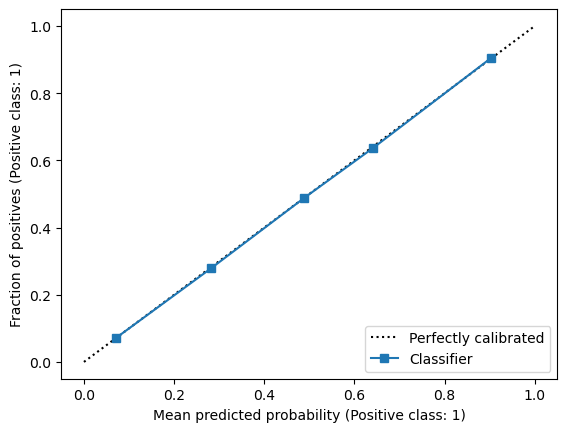

In [91]:
test_preds_proba_2 = rfc_estimator_2.predict_proba(X_fe_test)

CalibrationDisplay.from_predictions(y_test, test_preds_proba_2[:, 1])

In [92]:
log_loss(y_test, test_preds_proba_2)

0.3430743906099795

In [94]:
dump(rfc_estimator_2, "../models/rfc_seq_feat_sel.joblib")

['../models/rfc_seq_feat_sel.joblib']

The model with only 3 features is perfectly calibrated! But the log_loss in the test set is higher than the previous classifier